# Load Libraries

In [1]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

# Generic
import os
import matplotlib.pyplot as plt

# Images
from PIL import Image
from skimage.transform import resize
import talos as ta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix

# Tensorflow
import tensorflow as tf

# Keras
from keras.layers import Input, Dense, Dropout
from keras.utils import print_summary
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

Using TensorFlow backend.


# Load Classes and Functions

### CheXnet Functios

In [3]:
# chexNet weights
chexnet_weights = '/home/ygala/TFM_UOC/scripts/chexnet/best_weights.h5'

def chexnet_preprocess_input(value):
    return preprocess_input(value)


def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model

### Auxiliary Functions

In [4]:
def get_class_weight(csv_file_path, target_class):
    df = pd.read_csv(csv_file_path, sep=';')
    total_counts = df.shape[0]
    class_weight = []

    ratio_pos = df.loc[(df[target_class] == 'Y')].shape[0] / total_counts
    ratio_neg = df.loc[(df[target_class] == 'N')].shape[0] / total_counts
    class_weight = np.array((ratio_pos, ratio_neg))
        
    return class_weight

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def print_confidence_intervals(statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    mean = statistics.mean()
    max_ = np.quantile(statistics, .95)
    min_ = np.quantile(statistics, .05)
    df.loc["Exitus"] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_model(learning_rate):
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()

    x = base_model.output
    
    # Regularization layer
    x = BatchNormalization()(x)
    
    # Dense layer
    x = Dense(128, 
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(0.5, 0.0001))(x)
    
    # Regularization layer
    x = BatchNormalization()(x)

    
    # add a logistic layer -- let's say we have 6 classes
    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)

    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.0,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[metrics.BinaryAccuracy(name = "acc"),
                metrics.AUC(name = "auc")])

    return base_model, model


class print_learning_rate(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(f'Learning rate = {K.eval(lr):.5f}')



### Print Functions

In [ ]:
def grafica_entrenamiento(tr_auc, val_auc, tr_loss, val_loss, best_i,
                          figsize=(10,5), path_results = None):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_loss)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_loss)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=12)
    plt.xlabel('época', fontsize=18)        
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.subplot(1,2,2)
    
    plt.plot(1+np.arange(len(tr_auc)),  np.array(tr_auc))
    plt.plot(1+np.arange(len(val_auc)), np.array(val_auc))
    plt.plot(1+best_i, val_auc[best_i], 'or')
    plt.title('AUC', fontsize=18)
    plt.ylabel('AUC', fontsize=12)
    plt.xlabel('época', fontsize=18)    
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if (path_results != None):
        plt.savefig(os.path.join(path_results, 'auc_loss.png'))
    plt.show()
    
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.auc = []
        self.val_losses = []
        self.val_auc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):       
       
        
        # Before plotting ensure at least 10 epochs have passed
        if epoch > 20:
             # Append the logs, losses and accuracies to the lists
            self.logs.append(logs)        
            self.auc.append(logs.get('auc'))        
            self.val_auc.append(logs.get('val_auc'))
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))
            best_i = np.argmax(self.val_auc)
            grafica_entrenamiento(self.auc, self.val_auc, self.losses, self.val_losses, best_i)

### Talos functions

In [5]:
def get_model_talos(X_train, y_train, X_val, y_val, params):
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()

    x = base_model.output
    # one more layer (relu)
    x = Dense(params['first_neuron'], activation='relu')(x)

    # Dropout layer

    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=0.005,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.00001,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=[auc]
        #metrics=['accuracy']
        )
    
    
    # This callback writes logs for TensorBoard
    tensorboard = TensorBoard(
        log_dir='./Graph', 
        histogram_freq=0,  
        write_graph=True
    )

    my_callbacks = EarlyStopping(monitor='val_auc', patience=300, verbose=1, mode='max')

    callbacks_list = [tensorboard, my_callbacks]


    
    batch_size = params['batch_size']
    out = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val),
                     steps_per_epoch=len(X_train) / batch_size, 
                     epochs=params['epochs'],
                     class_weight=class_weight_train,
                     callbacks = callbacks_list,       
                     verbose=0)


    return out, model



# Global Parameters

In [8]:
perc_split = [0.7, 0.15, 0.15]
input_shape = (224, 224, 3)
seed = 143

# Load Data

In [9]:
path_root = '/home/ygala/TFM_UOC/'
path_images = os.path.join(path_root, 'data', 'covid_images')


## Read data

In [10]:
case_features = pd.read_csv(os.path.join(path_images, 'clean_data.csv'), sep=';');
case_features

,patientid,index,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,...,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,PixelData,filename,survival
0,1,362424,ISO_IR 100,Computed Radiography Image Storage,1.3.12.2.1107.5.3.56.2693.11.202004071536250109,20200407,153625.000,ACC00009757,CR,NaN,...,NaN,16,12,11,0,0,NaN,Array of 5549966 elements,362424.png,N
1,13,161101,ISO_IR 100,Computed Radiography Image Storage,1.3.12.2.1107.5.3.56.2693.11.202003210459280593,20200321,45928.000,ACC00005107,CR,NaN,...,NaN,16,12,11,0,0,NaN,Array of 6069570 elements,161101.png,Y
2,13,161102,ISO_IR 100,Computed Radiography Image Storage,1.3.12.2.1107.5.3.56.2693.11.202003260728100281,20200326,72810.000,ACC00005301,CR,NaN,...,NaN,16,12,11,0,0,NaN,Array of 5683394 elements,161102.png,Y
3,13,161103,ISO_IR 100,Computed Radiography Image Storage,1.3.12.2.1107.5.3.56.2693.11.202003220726220593,20200322,72622.000,ACC00005441,CR,NaN,...,NaN,16,12,11,0,0,NaN,Array of 5989198 elements,161103.png,Y
4,13,161104,ISO_IR 100,Computed Radiography Image Storage,1.3.12.2.1107.5.3.56.2693.11.202003221418280437,20200322,141828.000,ACC00005552,CR,NaN,...,NaN,16,12,11,0,0,NaN,Array of 5990704 elements,161104.png,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480,2278,460652,ISO_IR 100,Digital X-Ray Image Storage - For Presentation,1.3.46.670589.30.36.0.1.18774111139.1586556014...,20200410,225716.391,ACC00008725,DX,NaN,...,NaN,16,12,11,0,0,NaN,Array of 5674014 elements,460652.png,Y
3481,2280,461518,NaN,Computed Radiography Image Storage,1.3.51.0.7.11525005549.51456.28486.35726.61854...,20200415,103742.000,ACC00010093,CR,NaN,...,"[0.15, 0.15]",16,12,11,0,0,NaN,Array of 5694582 elements,461518.png,Y
3482,2286,466280,ISO_IR 100,Computed Radiography Image Storage,1.3.51.0.7.3142572467.2116.61512.35199.56756.9...,20200414,181443.000,ACC00009959,CR,NaN,...,"[0.15, 0.15]",16,12,11,0,0,NaN,Array of 6762522 elements,466280.png,Y
3483,2287,466281,ISO_IR 100,Computed Radiography Image Storage,1.3.51.0.7.12387810049.31749.41031.46011.30246...,20200415,95222.000,ACC00009454,CR,NaN,...,"[0.1, 0.1]",16,15,14,0,0,NaN,Array of 19441046 elements,466281.png,Y


In [11]:
case_features.shape

(3485, 38)

## Split data

In [12]:
target_class = 'survival'
np.random.seed(seed)

### Positive patient ids 
positive = case_features[case_features.survival.values == 'Y']
positive_ids = positive.patientid.unique()

### Negative patient ids 
negative = case_features[case_features.survival.values == 'N']
negative_ids = negative.patientid.unique()
n_negative_ids = len(negative_ids)

### Test
test_size = perc_split[2]*n_negative_ids
test_ids = np.append(np.random.choice(positive_ids, size = math.floor(test_size), replace = False),
                     np.random.choice(negative_ids, size = math.floor(test_size), replace = False))
positive_ids = positive_ids[~np.isin(positive_ids, test_ids)]
negative_ids = negative_ids[~np.isin(negative_ids, test_ids)]

### Val
val_size = perc_split[1]*n_negative_ids
val_ids = np.append(np.random.choice(positive_ids, size = math.floor(val_size), replace = False),
                     np.random.choice(negative_ids, size = math.floor(val_size), replace = False))
positive_ids = positive_ids[~np.isin(positive_ids, val_ids)]
negative_ids = negative_ids[~np.isin(negative_ids, val_ids)]

### Train
train_ids = np.append(positive_ids,
                    negative_ids)

# Split dataset based on patient ids
case_features_train = case_features[case_features.patientid.isin(train_ids)]
case_features_val = case_features[case_features.patientid.isin(val_ids)]
case_features_test = case_features[case_features.patientid.isin(test_ids)]

# Selección del patrón de datos X y del target y
ytrain = case_features_train[target_class]
del case_features_train[target_class]
Xtrain = case_features_train

yval = case_features_val[target_class]
del case_features_val[target_class]
Xval = case_features_val

ytest = case_features_test[target_class]
del case_features_test[target_class]
Xtest = case_features_test

In [13]:
print(len(case_features_train[ytrain == "Y"].patientid.unique()))
print(len(case_features_train[ytrain == "N"].patientid.unique()))
print(len(case_features_val[yval == "Y"].patientid.unique()))
print(len(case_features_val[yval == "N"].patientid.unique()))
print(len(case_features_test[ytest == "Y"].patientid.unique()))
print(len(case_features_test[ytest == "N"].patientid.unique()))

1120
151
25
25
25
25


In [14]:
print(case_features_train.shape)
print(case_features_val.shape)
print(case_features_test.shape)

(3210, 37)
(107, 37)
(168, 37)


In [15]:
print(ytrain.value_counts())
print(yval.value_counts())
print(ytest.value_counts())

Y    2703
N     507
Name: survival, dtype: int64
N    59
Y    48
Name: survival, dtype: int64
N    92
Y    76
Name: survival, dtype: int64


## Read images

### Train

In [17]:
X_train = []
for i in range(Xtrain.shape[0]):
    image_path = os.path.join(path_images, 'processed', Xtrain.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_train.append(imagen)

X_train = np.stack(X_train, axis = 0)
print(X_train.shape)

(3210, 224, 224, 3)


### Validation

In [18]:
X_val = []
for i in range(Xval.shape[0]):
    image_path = os.path.join(path_images, 'processed', Xval.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_val.append(imagen)

X_val = np.stack(X_val, axis = 0)
print(X_val.shape)

(107, 224, 224, 3)


### Test

In [21]:
X_test = []
for i in range(Xtest.shape[0]):
    # print('%0.2f%%' % float(100*i/Xtest.shape[0]))
    image_path = os.path.join(path_images, 'processed', Xtest.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_test.append(imagen)

X_test = np.stack(X_test, axis = 0)
print(X_test.shape)

(168, 224, 224, 3)


## Set target

### Train

In [22]:
ytrain[ytrain=='Y'] = 0
ytrain[ytrain=='N'] = 1
y_train = np.array(ytrain, dtype = np.int64)
y_train.shape

(3210,)

### Validation

In [23]:
yval[yval=='Y'] = 0
yval[yval=='N'] = 1
y_val = np.array(yval, dtype = np.int64)
y_val.shape

(107,)

### Test

In [24]:
ytest[ytest=='Y'] = 0
ytest[ytest=='N'] = 1
y_test = np.array(ytest, dtype = np.int64)
y_test.shape

(168,)

## Set class weights

### Train

In [25]:
ratio_pos = np.count_nonzero(y_train == 0) / len(y_train)
ratio_neg = np.count_nonzero(y_train == 1) / len(y_train)
class_weight_train = np.array((ratio_pos, ratio_neg))
print(class_weight_train)


[0.84205607 0.15794393]


### Validation

In [26]:
ratio_pos = np.count_nonzero(y_val == 0) / len(y_val)
ratio_neg = np.count_nonzero(y_val == 1) / len(y_val)
class_weight_val = np.array((ratio_pos, ratio_neg))
print(class_weight_val)


[0.44859813 0.55140187]


### Test

In [27]:
ratio_pos = np.count_nonzero(y_test == 0) / len(y_test)
ratio_neg = np.count_nonzero(y_test == 1) / len(y_test)
class_weight_test = np.array((ratio_pos, ratio_neg))
print(class_weight_test)

[0.45238095 0.54761905]


# Data Augmentation

In [28]:
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True, 
                             rotation_range=90)
datagen.fit(X_train)

# Model Definition

## Callbacks

### Checkpoints

In [29]:
save_dir = os.path.join(
    os.getcwd(),
    '../saved_models'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# This callback saves the weights of the model after each epoch
checkpoint = ModelCheckpoint(
    '../saved_models/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

# This callback writes logs for TensorBoard
tensorboard_augmented = TensorBoard(
    log_dir='./Graph_augmented', 
    histogram_freq=0,  
    write_graph=True
)

my_callbacks = EarlyStopping(monitor='val_auc', patience=200, verbose=1, mode='max')
my_callbacks_augmented = EarlyStopping(monitor='val_auc', patience=100, verbose=1, mode='max')


callbacks_list = [tensorboard, my_callbacks]
callbacks_list_augmented = [tensorboard_augmented, my_callbacks_augmented]

## Define CNN structure

# Hyperparameters tuning 

### Augmented dataset

In [ ]:

epochs = [ 10000]
batch_size = [32, 64, 128]
learning_rate = [0.1, 0.01, 0.001]

previous_val_auc = 0
df = pd.DataFrame()

for e in epochs:
    for b in batch_size:
        for l in learning_rate:
            print("Numero de épocas", e,", batch size", b,  ", learning rate", l)

            # Augmented
            base_model2, model2 = get_model(l)
            ###### ENTRENAMIENTO
            out = model2.fit_generator(datagen.flow(X_train, y_train, batch_size=b),
                                             validation_data=datagen.flow(X_val, y_val),
                                             steps_per_epoch=len(X_train) / b, 
                                             epochs=e,
                                             class_weight=class_weight_train,
                                             callbacks = callbacks_list_augmented,       
                                             verbose=0)

            train_loss = out.history['loss'][-1]
            val_loss = out.history['val_loss'][-1]
            train_auc = out.history['auc'][-1]
            val_auc = out.history['val_auc'][-1]
            stopped_epoch = my_callbacks.stopped_epoch
            model = out.model
            
            res = pd.DataFrame([e, l, b, stopped_epoch, train_loss, val_loss, train_auc, val_auc])
            df = pd.concat([df, res], axis=1)

            df.to_csv('model_results34.csv') 
            
            if(previous_val_auc < val_auc):
                save_dir = os.path.join(
                    os.getcwd(),
                    '../model_results_y'
                )
                if not os.path.isdir(save_dir):
                    os.makedirs(save_dir)
                model.save('../../model_results_y/model.h5')
                
                previous_val_auc = val_auc
                
            for e in range(epochs):    
                acum_tr_acc = acum_tr_acc + history.history['accuracy']
                acum_val_acc = acum_val_acc + history.history['val_accuracy']

                if len(acum_tr_acc) > 1:
                    clear_output()
                    grafica_entrenamiento(acum_tr_acc, acum_val_acc)
                           
df.index = ['epochs', 'learning_rate', 'batch_size',
            'early_stopping', 'train_loss', 'val_loss', 'train_auc', 'val_auc']
df.to_csv('model_results3.csv') 

Numero de épocas 10000 , batch size 256 , learning rate 0.01


In [ ]:
df.index = ['epochs', 'learning_rate', 'batch_size',
            'early_stopping', 'train_loss', 'val_loss', 'train_auc', 'val_auc']
df.to_csv('model_results4.csv') 

In [ ]:
df

In [36]:
out.history

{'val_loss': [1.0892773866653442,
  1.1244773864746094,
  0.8930120468139648,
  0.7819281220436096,
  1.3259198665618896,
  0.7867472171783447,
  0.8058971762657166,
  1.3188318014144897,
  0.6677631139755249,
  1.1565334796905518,
  1.3692364692687988,
  1.1375232934951782,
  1.3945266008377075,
  1.1553953886032104,
  1.7591633796691895,
  1.3566734790802002,
  1.6213066577911377,
  0.9622960686683655,
  1.2543214559555054,
  1.085792064666748,
  1.7223517894744873,
  1.3976962566375732,
  1.374426007270813,
  0.785800039768219,
  1.9895057678222656,
  1.0101350545883179,
  0.9067074060440063,
  1.2463587522506714,
  0.6698571443557739,
  1.315226435661316,
  1.1903095245361328,
  1.3676300048828125,
  1.0780596733093262,
  1.0966622829437256,
  0.6554526686668396,
  1.176869511604309,
  1.6392364501953125,
  1.2586866617202759,
  1.2779544591903687,
  1.3045169115066528,
  0.8743593692779541,
  1.5273231267929077,
  1.1861010789871216,
  1.2631207704544067,
  1.198837399482727,
  1.

### Predict

In [39]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

### Metrics

In [40]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

AUC train = 0.7008707543156445 - AUC val = 0.6345338983050848 - AUC test = 0.7000858123569793


In [44]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

[[2703    0]
 [ 507    0]]
[[48  0]
 [59  0]]
[[76  0]
 [92  0]]


In [45]:
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve



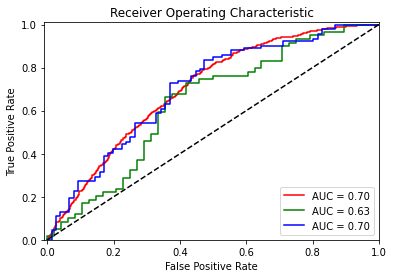

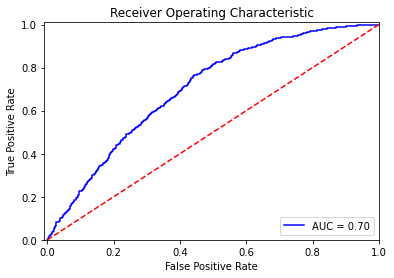

In [46]:

fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
fpr_val, tpr_val, threshold_val = roc_curve(y_val, pred_val)
roc_auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC = %0.2f' % roc_auc_test)
plt.plot(fpr_val, tpr_val, 'g', label = 'AUC = %0.2f' % roc_auc_val)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Save output

In [1]:
X_train.to_csv(os.path.join('../predictions_y', 'X_train.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_train.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_train.csv'), y_train, delimiter=";")
X_val.to_csv(os.path.join('../predictions_y', 'X_val.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_val.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_val.csv'), y_val, delimiter=";")
X_test.to_csv(os.path.join('../predictions_y', 'X_test.csv'))
np.savetxt(os.path.join('../predictions_y', 'predictions_test.csv'),pred_test, delimiter=";")
np.savetxt(os.path.join('../predictions_y', 'y_test.csv'), y_test, delimiter=";")

## TALOS

In [ ]:
import talos as ta

In [ ]:
p = {
    'first_neuron': [512],
    'epochs' :[20, 100],
    'batch_size': [10,15]
}


In [ ]:
t = ta.Scan(x = X_train, y = y_train, x_val = X_val, y_val = y_val, params = p, model = get_model_talos,
            experiment_name ='exp_1', print_params= True)

In [ ]:
###### ENTRENAMIENTO
history = model.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size, 
          nb_epoch=epochs,
          class_weight=class_weight_train,
          callbacks = callbacks_list,
          verbose=1)


In [ ]:
save_dir = os.path.join(
    os.getcwd(),
    '../model_results_y'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model.save('../model_results_y/fixed_model.h5')  

## Heatmap / Gradcam

In [ ]:
new_X_test = X_test[:, 0:185, :, :]
new_X_test.shape

In [ ]:
i = np.argmax(pred_test)
print('index ' + str(i));
heat_map, superimposed_img = show_heatmap(model_augmented, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
i = np.argmin(pred_test)
print('index ' + str(i));
heat_map, superimposed_img = show_heatmap(model_augmented, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
for i in np.where(y_test == 1)[0]:
    print('index ' + str(i));
    heat_map, superimposed_img = show_heatmap(model_augmented, new_X_test[i], y_test[i], pred_test[i])

In [ ]:
for i in np.where(y_test == 0)[0]:
    print('index ' + str(i));
    heat_map, superimposed_img = show_heatmap(model_augmented, new_X_test[i], y_test[i], pred_test[i])